In [1]:
!pip list | grep torch

torch                         2.9.1
torchvision                   0.24.1


In [2]:
import torch

*   https://pytorch.org/blog/quantization-in-practice/
*   https://pytorch.org/docs/stable/quantization.html
*   https://pytorch.org/docs/stable/quantization-support.html

### Mapping function and Quantization Parameters

In [3]:
# r - float tensor, r' - int tensor
# S [scaling factor] = (beta - alpha) / (beta_q - alpha_q)
# Z [zero point] =  -(alpha / S - alpha_q)

def quantize(float_tensor, scale, z):
  # Q(r) = round(r/S + Z)
  return torch.round(float_tensor / scale + z)

def dequantize(int_tensor, scale, z):
  # r' = (Q(r) - Z) * S
  return (int_tensor - z) * scale

In [4]:
from torch.ao.quantization.observer import MinMaxObserver, MovingAverageMinMaxObserver, HistogramObserver

C, L = 3, 4
normal = torch.distributions.normal.Normal(0,1)
inputs = normal.sample((C, L))
print(inputs)

tensor([[-0.1880, -0.0844,  1.4646,  0.1828],
        [ 0.0944, -0.2456,  0.3274,  0.1167],
        [-0.4556, -0.6780, -0.3045, -0.3583]])


In [5]:
observers = [MinMaxObserver(), MovingAverageMinMaxObserver(), HistogramObserver()]
for obs in observers:
  obs(inputs)
  print(obs.__class__.__name__, obs.calculate_qparams())

MinMaxObserver (tensor([0.0084]), tensor([81], dtype=torch.int32))
MovingAverageMinMaxObserver (tensor([0.0084]), tensor([81], dtype=torch.int32))
HistogramObserver (tensor([0.0084]), tensor([81], dtype=torch.int32))


In [6]:
scale, z = observers[0].calculate_qparams()
reconstruction_error = torch.abs(dequantize(quantize(inputs, scale, z), scale, z) - inputs)
reconstruction_error

tensor([[0.0032, 0.0004, 0.0026, 0.0021],
        [0.0020, 0.0019, 0.0003, 0.0010],
        [0.0019, 0.0026, 0.0020, 0.0030]])

### Affine and Symmetric Quantization Schemes

In [7]:
import numpy as np
import matplotlib.pyplot as plt


def get_symmetric_range(x):
  beta = torch.max(x.max(), x.min().abs())
  return -beta.item(), beta.item()

def get_affine_range(x):
  return x.min().item(), x.max().item()

def plot(plt, data, scheme):
  boundaries = get_affine_range(data) if scheme == 'affine' else get_symmetric_range(data)
  a, _, _ = plt.hist(data, density=True, bins=100)
  ymin, ymax = np.quantile(a[a>0], [0.25, 0.95])
  plt.vlines(x=boundaries, ls='--', colors='purple', ymin=ymin, ymax=ymax)

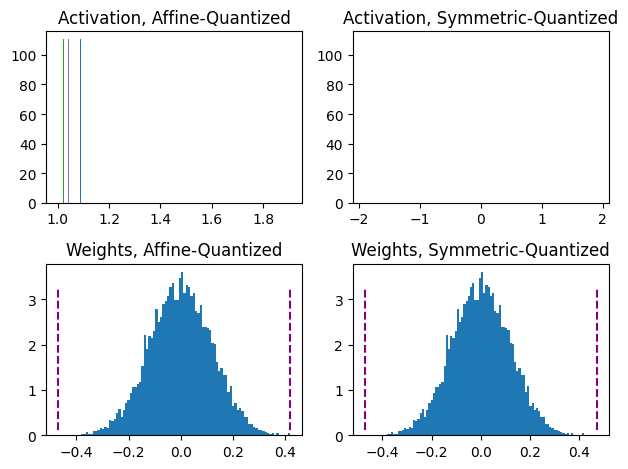

In [8]:
act =  torch.distributions.pareto.Pareto(1, 10).sample((1, 1024))
weights = torch.distributions.normal.Normal(0, 0.12).sample((3, 64, 7, 7)).flatten()

fig, axs = plt.subplots(2,2)
plot(axs[0, 0], act, 'affine')
axs[0, 0].set_title("Activation, Affine-Quantized")

plot(axs[0, 1], act, 'symmetric')
axs[0, 1].set_title("Activation, Symmetric-Quantized")

plot(axs[1, 0], weights, 'affine')
axs[1, 0].set_title("Weights, Affine-Quantized")

plot(axs[1, 1], weights, 'symmetric')
axs[1, 1].set_title("Weights, Symmetric-Quantized")

fig.tight_layout()
plt.show()

In [9]:
for qscheme in [torch.per_tensor_affine, torch.per_tensor_symmetric]:
  obs = MovingAverageMinMaxObserver(qscheme=qscheme)
  obs(inputs)
  print(f"Qscheme: {qscheme} | {obs.calculate_qparams()}")

Qscheme: torch.per_tensor_affine | (tensor([0.0084]), tensor([81], dtype=torch.int32))
Qscheme: torch.per_tensor_symmetric | (tensor([0.0115]), tensor([128]))


### Per-Tensor and Per-Channel Quantization Schemes

In [10]:
from torch.ao.quantization.observer import MovingAveragePerChannelMinMaxObserver

obs = MovingAveragePerChannelMinMaxObserver(ch_axis = 0)  # calculate qparams for all `C` channels separately
obs(inputs)
print(obs.calculate_qparams())

(tensor([0.0065, 0.0022, 0.0027]), tensor([ 29, 109, 255], dtype=torch.int32))


For weights quantization, symmetric-per-channel quantization provides better accuracies; per-tensor quantization performs poorly, possibly due to high variance in conv weights across channels from batchnorm folding.
[https://arxiv.org/abs/2004.09602]

https://github.com/pytorch/pytorch/blob/748d9d24940cd17938df963456c90fa1a13f3932/torch/ao/quantization/observer.py#L258

### Backend Engine

In [11]:
backend = 'fbgemm' #'fbgemm' if x86 else 'qnnpack'
qconfig = torch.ao.quantization.get_default_qconfig(backend)
torch.backends.quantized.engine = backend

GPUs - via TensorRT and cuDNN
https://pytorch.org/docs/stable/quantization.html#note-for-native-cpu-backends

### QConfig

In [12]:
my_qconfig = torch.ao.quantization.QConfig(
  activation=MovingAverageMinMaxObserver.with_args(qscheme=torch.per_tensor_affine),
  weight=MovingAveragePerChannelMinMaxObserver.with_args(qscheme=torch.qint8))

my_qconfig

QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.MovingAverageMinMaxObserver'>, qscheme=torch.per_tensor_affine){}, weight=functools.partial(<class 'torch.ao.quantization.observer.MovingAveragePerChannelMinMaxObserver'>, qscheme=torch.qint8){})

### Eager Mode v/s FX Graph Mode

*    Eager Mode Quantization is a beta feature. User needs to do fusion and specify where quantization and dequantization happens manually, also it only supports modules and not functionals.
*    FX Graph Mode Quantization is a new automated quantization framework in PyTorch, and currently it’s a prototype feature. It improves upon Eager Mode Quantization by adding support for functionals and automating the quantization process, although people might need to refactor the model to make the model compatible with FX Graph Mode Quantization (symbolically traceable with torch.fx)






FX Graph Mode automatically fuses eligible modules, inserts Quant/DeQuant stubs, calibrates the model and returns a quantized module - all in two method calls - but only for networks that are symbolic traceable. The examples below contain the calls using Eager Mode and FX Graph Mode for comparison.
https://pytorch.org/docs/stable/fx.html#torch.fx.symbolic_trace

In [ ]:
def f(a, b):
    if b == True:
        return a
    else:
        return a * 2

In [ ]:
f = torch.fx.symbolic_trace(f, concrete_args={'b': False})
assert f(3, False) == 6

https://pytorch.org/docs/stable/fx.html

### Post-Training Dynamic/Weight-only Quantization

Here the model’s weights are pre-quantized; the activations are quantized on-the-fly (“dynamic”) during inference. The simplest of all approaches, it has a one line API call in torch.quantization.quantize_dynamic. Currently only Linear and Recurrent (LSTM, GRU, RNN) layers are supported for dynamic quantization



*   Can result in higher accuracies since the clipping range is exactly calibrated for each input
*   Calibrating and quantizing the activations at each layer during runtime can add to the compute overhead



In [ ]:
from torch import nn

# toy model
m = nn.Sequential(
  nn.Conv2d(2, 64, (8,)),
  nn.ReLU(),
  nn.Linear(16, 10),
  nn.LSTM(10, 10))

m.eval()

Sequential(
  (0): Conv2d(2, 64, kernel_size=(8,), stride=(1, 1))
  (1): ReLU()
  (2): Linear(in_features=16, out_features=10, bias=True)
  (3): LSTM(10, 10)
)

In [ ]:
## EAGER MODE
from torch.ao.quantization import quantize_dynamic

model_quantized = quantize_dynamic(
    model=m, qconfig_spec={nn.LSTM, nn.Linear}, dtype=torch.qint8, inplace=False
)

/tmp/ipython-input-2181302342.py:4: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  model_quantized = quantize_dynamic(


In [ ]:
## FX MODE
from torch.ao.quantization import quantize_fx

example_inputs = (torch.randn(1, 3, 224, 224),)
qconfig_dict = {"": torch.ao.quantization.default_dynamic_qconfig}  # An empty key denotes the default applied to all modules
model_prepared = quantize_fx.prepare_fx(m, qconfig_dict, example_inputs)
model_quantized = quantize_fx.convert_fx(model_prepared)

/tmp/ipython-input-15622409.py:6: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  model_prepared = quantize_fx.prepare_fx(m, qconfig_dict, example_inputs)
/usr/local/lib/python3.12/dist-packages/torch/ao/quantization/quantize_fx.py:146: FutureWarning: Passing a QConfig dictionary to prepare is deprecated and will not be supported in a future version. Please pass in a QConf

### Post-Training Static Quantization (PTQ)

PTQ also pre-quantizes model weights but instead of calibrating activations on-the-fly, the clipping range is pre-calibrated and fixed (“static”) using validation data. Activations stay in quantized precision between operations during inference. About 100 mini-batches of representative data are sufficient to calibrate the observers

*   Static quantization has faster inference than dynamic quantization because it eliminates the float<->int conversion costs between layers
*   Static quantized models may need regular re-calibration to stay robust against distribution-drift



In [ ]:
# Static quantization of a model consists of the following steps:

#     Fuse modules
#     Insert Quant/DeQuant Stubs
#     Prepare the fused module (insert observers before and after layers)
#     Calibrate the prepared module (pass it representative data)
#     Convert the calibrated module (replace with quantized version)

import torch
from torch import nn
import copy

backend = "fbgemm"  # running on a x86 CPU. Use "qnnpack" if running on ARM.

model = nn.Sequential(
     nn.Conv2d(2, 64, 3),
     nn.ReLU(),
     nn.Conv2d(64, 128, 3),
     nn.ReLU()
)

In [ ]:
model[0].weight

Parameter containing:
tensor([[[[-0.1928, -0.1054,  0.2114],
          [-0.0647,  0.2293, -0.1385],
          [-0.1778,  0.0213, -0.2144]],

         [[ 0.0457,  0.2161,  0.1104],
          [ 0.0996, -0.1576,  0.0593],
          [-0.1849,  0.1239,  0.1911]]],


        [[[-0.0240, -0.2256, -0.1008],
          [-0.0429, -0.0425, -0.2341],
          [ 0.0884, -0.1269, -0.2153]],

         [[-0.0279, -0.1518, -0.0319],
          [-0.1016,  0.1213,  0.2062],
          [-0.0347,  0.0668,  0.0152]]],


        [[[ 0.1080, -0.1748,  0.1471],
          [ 0.1659, -0.1662, -0.2282],
          [ 0.2282,  0.1972,  0.1749]],

         [[-0.0635, -0.2079,  0.1717],
          [ 0.0424, -0.2030, -0.1405],
          [ 0.2111, -0.0697, -0.1182]]],


        ...,


        [[[ 0.0694,  0.2069, -0.1728],
          [ 0.1395,  0.2033,  0.1809],
          [ 0.0878, -0.2317, -0.1280]],

         [[-0.0883,  0.1499,  0.0371],
          [-0.0213,  0.1029,  0.1026],
          [-0.0526,  0.1986, -0.2077]]],


   

In [ ]:
## EAGER MODE
m = copy.deepcopy(model)
m.eval()

"""Fuse
- Inplace fusion replaces the first module in the sequence with the fused module, and the rest with identity modules
"""
torch.ao.quantization.fuse_modules(m, ['0','1'], inplace=True) # fuse first Conv-ReLU pair
torch.ao.quantization.fuse_modules(m, ['2','3'], inplace=True) # fuse second Conv-ReLU pair

"""Insert stubs"""
m = nn.Sequential(torch.ao.quantization.QuantStub(),
                  *m,
                  torch.ao.quantization.DeQuantStub())

"""Prepare"""
m.qconfig = torch.ao.quantization.get_default_qconfig(backend)
torch.ao.quantization.prepare(m, inplace=True)

"""Calibrate
- This example uses random data for convenience. Use representative (validation) data instead.
"""
with torch.inference_mode():
  for _ in range(10):
    x = torch.rand(1, 2, 28, 28)
    m(x)

"""Convert"""
torch.ao.quantization.convert(m, inplace=True)

"""Check"""
print(m[1].weight().element_size()) # 1 byte instead of 4 bytes for FP32

1


/tmp/ipython-input-213743822.py:18: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  torch.ao.quantization.prepare(m, inplace=True)
/usr/local/lib/python3.12/dist-packages/torch/ao/quantization/observer.py:246: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorc

In [ ]:
m[1].weight()

tensor([[[[-0.1924, -0.1061,  0.2122],
          [-0.0647,  0.2284, -0.1385],
          [-0.1780,  0.0216, -0.2140]],

         [[ 0.0450,  0.2158,  0.1097],
          [ 0.0989, -0.1582,  0.0593],
          [-0.1852,  0.1241,  0.1906]]],


        [[[-0.0239, -0.2258, -0.1010],
          [-0.0422, -0.0422, -0.2350],
          [ 0.0881, -0.1267, -0.2148]],

         [[-0.0275, -0.1524, -0.0312],
          [-0.1010,  0.1212,  0.2056],
          [-0.0349,  0.0661,  0.0147]]],


        [[[ 0.1074, -0.1754,  0.1468],
          [ 0.1665, -0.1665, -0.2291],
          [ 0.2273,  0.1969,  0.1754]],

         [[-0.0626, -0.2076,  0.1718],
          [ 0.0430, -0.2023, -0.1396],
          [ 0.2112, -0.0698, -0.1181]]],


        ...,


        [[[ 0.0691,  0.2072, -0.1727],
          [ 0.1399,  0.2036,  0.1817],
          [ 0.0872, -0.2326, -0.1272]],

         [[-0.0891,  0.1490,  0.0363],
          [-0.0218,  0.1036,  0.1018],
          [-0.0527,  0.1981, -0.2072]]],


        [[[ 0.2247,  0.14

In [ ]:
## FX GRAPH
from torch.ao.quantization import quantize_fx

m = copy.deepcopy(model)
m.eval()
qconfig_dict = {"": torch.ao.quantization.get_default_qconfig(backend)}

# Prepare
example_inputs = (torch.randn(1, 3, 224, 224),)
model_prepared = quantize_fx.prepare_fx(m, qconfig_dict, example_inputs)

# Calibrate - Use representative (validation) data.
with torch.inference_mode():
  for _ in range(10):
    x = torch.rand(1, 2, 28, 28)
    model_prepared(x)

# quantize
model_quantized = quantize_fx.convert_fx(model_prepared)

/tmp/ipython-input-750729956.py:10: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  model_prepared = quantize_fx.prepare_fx(m, qconfig_dict, example_inputs)
/usr/local/lib/python3.12/dist-packages/torch/ao/quantization/quantize_fx.py:146: FutureWarning: Passing a QConfig dictionary to prepare is deprecated and will not be supported in a future version. Please pass in a QCo

In [ ]:
m[0].weight

Parameter containing:
tensor([[[[-0.1928, -0.1054,  0.2114],
          [-0.0647,  0.2293, -0.1385],
          [-0.1778,  0.0213, -0.2144]],

         [[ 0.0457,  0.2161,  0.1104],
          [ 0.0996, -0.1576,  0.0593],
          [-0.1849,  0.1239,  0.1911]]],


        [[[-0.0240, -0.2256, -0.1008],
          [-0.0429, -0.0425, -0.2341],
          [ 0.0884, -0.1269, -0.2153]],

         [[-0.0279, -0.1518, -0.0319],
          [-0.1016,  0.1213,  0.2062],
          [-0.0347,  0.0668,  0.0152]]],


        [[[ 0.1080, -0.1748,  0.1471],
          [ 0.1659, -0.1662, -0.2282],
          [ 0.2282,  0.1972,  0.1749]],

         [[-0.0635, -0.2079,  0.1717],
          [ 0.0424, -0.2030, -0.1405],
          [ 0.2111, -0.0697, -0.1182]]],


        ...,


        [[[ 0.0694,  0.2069, -0.1728],
          [ 0.1395,  0.2033,  0.1809],
          [ 0.0878, -0.2317, -0.1280]],

         [[-0.0883,  0.1499,  0.0371],
          [-0.0213,  0.1029,  0.1026],
          [-0.0526,  0.1986, -0.2077]]],


   

### SENSITIVITY ANALYSIS

In [ ]:
# ONE-AT-A-TIME SENSITIVITY ANALYSIS

for quantized_layer, _ in model.named_modules():
  print("Only quantizing layer: ", quantized_layer)

  # The module_name key allows module-specific qconfigs.
  qconfig_dict = {"": None,
  "module_name":[(quantized_layer, torch.quantization.get_default_qconfig(backend))]}

  example_inputs = (torch.randn(1, 3, 224, 224),)
  model_prepared = quantize_fx.prepare_fx(model, qconfig_dict, example_inputs)
  # calibrate
  model_quantized = quantize_fx.convert_fx(model_prepared)
  # evaluate(model)

Only quantizing layer:  
Only quantizing layer:  0
Only quantizing layer:  1
Only quantizing layer:  2
Only quantizing layer:  3


/tmp/ipython-input-1147990886.py:11: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  model_prepared = quantize_fx.prepare_fx(model, qconfig_dict, example_inputs)
/tmp/ipython-input-1147990886.py:13: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torc

 Numeric Suite - https://pytorch.org/tutorials/prototype/numeric_suite_tutorial.html

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import os
import torch.ao.quantization
import torch.ao.ns._numeric_suite as ns
from torch.ao.quantization import (
    default_eval_fn,
    default_qconfig,
    quantize,
)

In [ ]:
float_model = torchvision.models.quantization.resnet18(pretrained=True, quantize=False)
float_model.to('cpu')
float_model.eval()
float_model.fuse_model()
float_model.qconfig = torch.quantization.default_qconfig
img_data = (torch.rand(2, 3, 10, 10, dtype=torch.float), torch.randint(0, 1, (2,), dtype=torch.long))
qmodel = quantize(float_model, default_eval_fn, [[img_data]], inplace=False)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 202MB/s]
/tmp/ipython-input-409614095.py:7: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  qmodel = quantize(float_model, default_eval_fn, [[img_data]], inplace=False)


In [ ]:
def compute_error(x, y):
    Ps = torch.norm(x)
    Pn = torch.norm(x - y)
    return 20 * torch.log10(Ps/Pn)

wt_compare_dict = ns.compare_weights(float_model.state_dict(), qmodel.state_dict())
for key in wt_compare_dict:
    print(key, compute_error(wt_compare_dict[key]['float'], wt_compare_dict[key]['quantized'].dequantize()))

print("---")

act_compare_dict = ns.compare_model_outputs(float_model, qmodel, img_data[0])
for key in act_compare_dict:
    print(key, compute_error(act_compare_dict[key]['float'][0], act_compare_dict[key]['quantized'][0].dequantize()))


conv1.weight tensor(31.6638)
layer1.0.conv1.weight tensor(30.6450)
layer1.0.conv2.weight tensor(31.1528)
layer1.1.conv1.weight tensor(32.1438)
layer1.1.conv2.weight tensor(31.2477)
layer2.0.conv1.weight tensor(30.9890)
layer2.0.conv2.weight tensor(28.8233)
layer2.0.downsample.0.weight tensor(31.5558)
layer2.1.conv1.weight tensor(30.7668)
layer2.1.conv2.weight tensor(28.4516)
layer3.0.conv1.weight tensor(30.9247)
layer3.0.conv2.weight tensor(26.6841)
layer3.0.downsample.0.weight tensor(28.7825)
layer3.1.conv1.weight tensor(28.9707)
layer3.1.conv2.weight tensor(25.6784)
layer4.0.conv1.weight tensor(26.8495)
layer4.0.conv2.weight tensor(25.8394)
layer4.0.downsample.0.weight tensor(28.6355)
layer4.1.conv1.weight tensor(26.8758)
layer4.1.conv2.weight tensor(28.4319)
fc._packed_params._packed_params tensor(32.6505)
---
conv1.stats tensor(37.4195, grad_fn=<MulBackward0>)
layer1.0.conv1.stats tensor(29.9686, grad_fn=<MulBackward0>)
layer1.0.conv2.stats tensor(28.8940, grad_fn=<MulBackward0>)
l

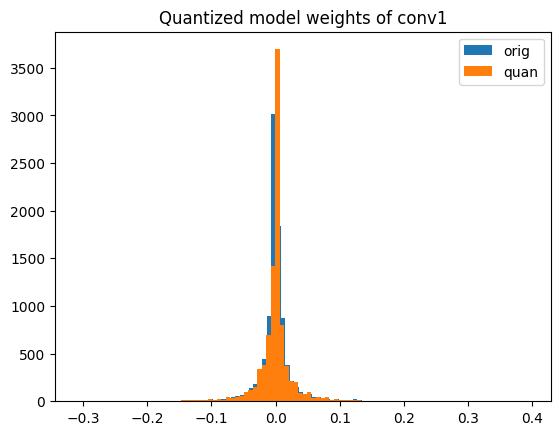

In [ ]:
import matplotlib.pyplot as plt

f = wt_compare_dict['conv1.weight']['float'].flatten()
plt.hist(f, bins = 100, label='orig')

q = wt_compare_dict['conv1.weight']['quantized'].flatten().dequantize()
plt.hist(q, bins = 100, label='quan')
plt.title("Quantized model weights of conv1")
plt.legend()
plt.show()

### RECOMMENDATIONS FOR YOUR WORKFLOW

![](https://drive.google.com/uc?export=view&id=1ij7GElwiKFNmJ221aKpkDRwMj5i-2DLh)



*   Large (10M+ parameters) models are more robust to quantization error
*   Quantizing a model from a FP32 checkpoint provides better accuracy than training an INT8 model from scratch
*   Dynamic Quantization is an easy first step, especially if your model has many Linear or Recurrent layers
*   Use symmetric-per-channel quantization with MinMax observers for quantizing weights. Use affine-per-tensor quantization with MovingAverageMinMax observers for quantizing activations
*   Use metrics like SQNR to identify which layers are most suscpetible to quantization error. Turn off quantization on these layers

Eager mode https://pytorch.org/docs/stable/quantization.html#eager-mode-quantization



*   https://pytorch.org/docs/stable/quantization.html#post-training-dynamic-quantization
*   https://pytorch.org/docs/stable/quantization.html#post-training-static-quantization


FX Graph https://pytorch.org/docs/stable/quantization.html#prototype-fx-graph-mode-quantization



*   https://pytorch.org/tutorials/prototype/fx_graph_mode_ptq_static.html
*   https://pytorch.org/tutorials/prototype/fx_graph_mode_ptq_dynamic.html





## New forkflow with torchao



In [ ]:
!pip install torchao

In [ ]:
import copy
import torch

class ToyLinearModel(torch.nn.Module):
    def __init__(self, m: int, n: int, k: int):
        super().__init__()
        self.linear1 = torch.nn.Linear(m, n, bias=False)
        self.linear2 = torch.nn.Linear(n, k, bias=False)

    def forward(self, x):
        x = self.linear1(x)
        x = self.linear2(x)
        return x

model = ToyLinearModel(1024, 1024, 1024).eval()

# Optional: compile model for faster inference and generation
model = torch.compile(model, mode="max-autotune", fullgraph=True)
model_f32 = copy.deepcopy(model)


In [ ]:
from torchao.quantization import Int4DynamicActivationInt4WeightConfig, quantize_
quantize_(model, Int4DynamicActivationInt4WeightConfig())

In [ ]:
from torchao.utils import (
    benchmark_model,
    unwrap_tensor_subclass,
)

num_runs = 100
torch._dynamo.reset()
example_inputs = (torch.randn(1, 1024, dtype=torch.float32),)
f32_time = benchmark_model(model_f32, num_runs, example_inputs)
int4_time = benchmark_model(model, num_runs, example_inputs)

print("f32 mean time: %0.3f ms" % f32_time)
print("int4 mean time: %0.3f ms" % int4_time)
print("speedup: %0.1fx" % (f32_time / int4_time))

f32 mean time: 0.193 ms
int4 mean time: 0.073 ms
speedup: 2.7x


In [ ]:
import os
torch.save(model, "/tmp/int4_model.pt")
torch.save(model_f32, "/tmp/f32_model.pt")
int4_model_size_mb = os.path.getsize("/tmp/int4_model.pt") / 1024 / 1024
f32_model_size_mb = os.path.getsize("/tmp/f32_model.pt") / 1024 / 1024

print("int4 model size: %.2f MB" % int4_model_size_mb)

print("f32 model size: %.2f MB" % f32_model_size_mb)


int4 model size: 1.01 MB
f32 model size: 8.00 MB


### Neural Network Compression Framework (NNCF)

In [ ]:
!git clone https://github.com/openvinotoolkit/nncf

Cloning into 'nncf'...
remote: Enumerating objects: 89023, done.
remote: Counting objects: 100% (1253/1253), done.
remote: Compressing objects: 100% (838/838), done.
remote: Total 89023 (delta 857), reused 428 (delta 415), pack-reused 87770 (from 2)
Receiving objects: 100% (89023/89023), 66.65 MiB | 24.28 MiB/s, done.
Resolving deltas: 100% (59899/59899), done.
Filtering content: 100% (149/149), 32.33 MiB | 13.72 MiB/s, done.


In [ ]:
# %%capture
%cd nncf
!pip install .[torch]
%cd /content

/content/nncf
Processing /content/nncf
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.7/72.7 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 139.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.8/303.8 kB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 kB 8.8 MB/s eta 0:00:00
  Created wheel for nncf: filename=nncf-2.19.0.dev0+9faf5592d-py3-none-any.whl size=1483075 sha256=4539073178f2b404ce7f3316ba7cdfc0dbc3fc8bcc452e3033b512bdc7e3b18d
  Stored in directory: /tmp/pip-ephem-wheel-cache-v9xl0_fz/wheels/ec/bf/bd/19a8710a6d2870ddb4197995c1a9fea9c

/content


In [ ]:
import torch
import nncf.torch  # Important - must be imported before any other external package that depends on torch

https://github.com/openvinotoolkit/nncf/tree/develop
https://github.com/openvinotoolkit/nncf/blob/develop/docs/compression_algorithms/Quantization.md
https://github.com/openvinotoolkit/nncf/blob/develop/examples/torch/classification/configs/quantization/inception_v3_imagenet_int8.json

https://dev-discuss.pytorch.org/t/torch-ao-quantization-migration-plan/2810
https://docs.pytorch.org/ao/stable

**Домашнее задание**: реализовать Post Training Quantization для предобученной float32 torch2 модели на выбранном наборе данных. Квантизация обязательно должна проводиться с использованием калибровочной подвыборки. К результатам прилагаются мини результаты исследования влияния гиперпараметров квантизации (см. начало ноутбка). Необходимо показать разные варианты с учетом и без SENSITIVITY анализа. Разрешается использовать дополнительные фреймворки после обсуждения. Важно наличие таблиц скорость / качество.

In [14]:
import time
import copy
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.models import resnet18

data_folder = "./data"
batch_size = 64
num_calib_batches = 50

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

train_data = datasets.CIFAR10(
    root=data_folder, train=True, download=True, transform=transform
)
test_data = datasets.CIFAR10(
    root=data_folder, train=False, download=True, transform=transform
)

calib_size = 1024
test_size = 5000

calib_data, _ = random_split(train_data, [calib_size, len(train_data) - calib_size])
test_data, _ = random_split(test_data, [test_size, len(test_data) - test_size])

calib_loader = DataLoader(calib_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print("Создаем модель ResNet18...")
model = resnet18(pretrained=True)

model.fc = nn.Linear(model.fc.in_features, 10)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

for epoch in range(3):
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f"Эпоха {epoch+1}, средний loss: {total_loss/len(train_loader):.4f}")

model.eval()
model = model.cpu()
float_model = copy.deepcopy(model)

def check_accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in data_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy
def check_speed(model, data_loader, num_batches=50):
    model.eval()
    times = []
    for i in range(10):
        images, _ = next(iter(data_loader))
        _ = model(images)
    
    for i in range(num_batches):
        images, _ = next(iter(data_loader))
        
        start = time.time()
        _ = model(images)
        end = time.time()
        
        times.append(end - start)
    
    avg_time = sum(times) / len(times) * 1000  # в миллисекундах
    return avg_time

print("\nПроверяем точность оригинальной модели...")
original_accuracy = check_accuracy(float_model, test_loader)
print(f"Точность оригинальной модели: {original_accuracy:.2f}%")

print("Проверяем скорость оригинальной модели...")
original_speed = check_speed(float_model, test_loader)
print(f"Скорость оригинальной модели: {original_speed:.2f} мс")

Создаем модель ResNet18...
Обучаем модель...


/home/livanoff/miniforge3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/livanoff/miniforge3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Эпоха 1, средний loss: 0.9129
Эпоха 2, средний loss: 0.6255
Эпоха 3, средний loss: 0.5878

Модель обучена!

Проверяем точность оригинальной модели...
Точность оригинальной модели: 80.26%
Проверяем скорость оригинальной модели...
Скорость оригинальной модели: 796.40 мс


In [ ]:
print("\n" + "="*50)
print("Полная квантизация модели...")

import torch.ao.quantization as tq
from torch.ao.quantization.quantize_fx import prepare_fx, convert_fx

qconfig = tq.get_default_qconfig("fbgemm")

model_to_quantize = copy.deepcopy(float_model)
model_to_quantize.eval()

example_input = next(iter(calib_loader))[0][:1]  # один пример
qconfig_dict = {"": qconfig}

prepared_model = prepare_fx(model_to_quantize, qconfig_dict, example_input)

print("Калибровка модели...")
with torch.no_grad():
    count = 0
    for images, _ in calib_loader:
        prepared_model(images)
        count += 1
        if count >= num_calib_batches:
            break

quantized_model = convert_fx(prepared_model)

print("Проверяем квантизованную модель...")
quantized_accuracy = check_accuracy(quantized_model, test_loader)
print(f"Точность квантизованной модели: {quantized_accuracy:.2f}%")

quantized_speed = check_speed(quantized_model, test_loader)
print(f"Скорость квантизованной модели: {quantized_speed:.2f} мс")

print("\n" + "="*50)
print("Анализ чувствительности по слоям...")

layer_names = []
for name, module in float_model.named_modules():
    if isinstance(module, (nn.Conv2d, nn.Linear)):
        layer_names.append(name)

layer_names = layer_names[:10]
results = []

for layer_name in layer_names:
    print(f"\nТестируем слой: {layer_name}")
    
    test_model = copy.deepcopy(float_model)
    test_model.eval()
    
    example_input = next(iter(calib_loader))[0][:1]
    
    qconfig_dict = {
        "": None,  # по умолчанию не квантизируем
        "module_name": [(layer_name, qconfig)],  # квантизируем только этот слой
    }
    
    prepared = prepare_fx(test_model, qconfig_dict, example_input)
    
    with torch.no_grad():
        count = 0
        for images, _ in calib_loader:
            prepared(images)
            count += 1
            if count >= num_calib_batches:
                break
    
    quantized = convert_fx(prepared)
    
    acc = check_accuracy(quantized, test_loader)
    drop = original_accuracy - acc
    
    print(f"  Точность: {acc:.2f}%")
    print(f"  Падение точности: {drop:.2f}%")
    
    results.append({
        "Слой": layer_name,
        "Точность": acc,
        "Падение": drop
    })

print("\n" + "="*50)
print("Самые проблемные слои (наибольшее падение точности):")

results.sort(key=lambda x: x["Падение"], reverse=True)

for i, result in enumerate(results[:5]):
    print(f"{i+1}. {result['Слой']}: падение {result['Падение']:.2f}%")

print("\n" + "="*50)
print("Создаем модель с пропуском 3 самых проблемных слоев...")

skip_layers = [results[0]["Слой"], results[1]["Слой"], results[2]["Слой"]]
print(f"Пропускаем слои: {skip_layers}")

final_model = copy.deepcopy(float_model)
final_model.eval()

example_input = next(iter(calib_loader))[0][:1]

qconfig_dict = {
    "": qconfig,  # квантизируем все по умолчанию
    "module_name": [(name, None) for name in skip_layers],  # не квантизируем проблемные слои
}

prepared_final = prepare_fx(final_model, qconfig_dict, example_input)

with torch.no_grad():
    count = 0
    for images, _ in calib_loader:
        prepared_final(images)
        count += 1
        if count >= num_calib_batches:
            break

final_quantized = convert_fx(prepared_final)

print("\nПроверяем итоговую модель...")
final_accuracy = check_accuracy(final_quantized, test_loader)
final_speed = check_speed(final_quantized, test_loader)

print(f"Точность итоговой модели: {final_accuracy:.2f}%")
print(f"Скорость итоговой модели: {final_speed:.2f} мс")

print("\n" + "="*50)
print("ИТОГОВОЕ СРАВНЕНИЕ:")
print(f"{'Модель':<30} {'Точность (%)':<15} {'Скорость (мс)':<15}")
print("-" * 60)
print(f"{'Оригинальная':<30} {original_accuracy:<15.2f} {original_speed:<15.2f}")
print(f"{'Полностью квантизованная':<30} {quantized_accuracy:<15.2f} {quantized_speed:<15.2f}")
print(f"{'С пропуском слоев':<30} {final_accuracy:<15.2f} {final_speed:<15.2f}")


Полная квантизация модели...


/tmp/ipykernel_16258/1372822852.py:15: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  prepared_model = prepare_fx(model_to_quantize, qconfig_dict, example_input)
/home/livanoff/miniforge3/lib/python3.12/site-packages/torch/ao/quantization/quantize_fx.py:146: FutureWarning: Passing a QConfig dictionary to prepare is deprecated and will not be supported in a future version.

Калибровка модели...


/tmp/ipykernel_16258/1372822852.py:26: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  quantized_model = convert_fx(prepared_model)


In [ ]:
import torch.ao.quantization as tq

from torch.ao.quantization.quantize_fx import prepare_fx, convert_fx

all_results = []

# Проверяем базовую модель
print("Проверяем базовую модель (FP32)...")
base_acc = check_accuracy(float_model, test_loader)
base_speed = check_speed(float_model, test_loader)

all_results.append({
    "Модель": "Базовая FP32",
    "Тип": "FP32",
    "Использован анализ": "Нет",
    "Точность (%)": round(base_acc, 2),
    "Скорость (мс)": round(base_speed, 2)
})

print(f"Точность: {base_acc:.2f}%, Скорость: {base_speed:.2f} мс")

# Список разных методов квантизации для тестирования
quantization_methods = [
    {
        "название": "Стандартная квантизация",
        "описание": "PTQ с настройками по умолчанию",
        "настройки": "default"
    },
    {
        "название": "Квантизация с гистограммой",
        "описание": "PTQ с HistogramObserver",
        "настройки": "histogram"
    }
]

# Тестируем разные методы квантизации
print("\n" + "="*50)
print("Тестируем разные методы квантизации...")

for method in quantization_methods:
    print(f"\n{method['название']}: {method['описание']}")
    
    if method['настройки'] == "default":
        qconfig = tq.get_default_qconfig("fbgemm")
    else:
        qconfig = tq.QConfig(
            activation=tq.HistogramObserver.with_args(
                dtype=torch.quint8,
                qscheme=torch.per_tensor_affine
            ),
            weight=tq.PerChannelMinMaxObserver.with_args(
                dtype=torch.qint8,
                qscheme=torch.per_channel_symmetric
            ),
        )
    
    model_copy = copy.deepcopy(float_model)
    model_copy.eval()
    
    example_input = next(iter(calib_loader))[0][:1]
    prepared = prepare_fx(model_copy, {"": qconfig}, example_input)
    
    with torch.no_grad():
        count = 0
        for images, _ in calib_loader:
            prepared(images)
            count += 1
            if count >= 30:
                break
    
    quantized_model = convert_fx(prepared)
    
    acc = check_accuracy(quantized_model, test_loader)
    speed = check_speed(quantized_model, test_loader)
    
    print(f"  Точность: {acc:.2f}%")
    print(f"  Скорость: {speed:.2f} мс")
    
    all_results.append({
        "Модель": f"PTQ: {method['название']}",
        "Тип": "PTQ",
        "Использован анализ": "Нет",
        "Точность (%)": round(acc, 2),
        "Скорость (мс)": round(speed, 2)
    })

print("\n" + "="*50)
print("Анализ чувствительности слоев...")

sensitivity_results = []
for layer_name in layer_names:
    print(f"Тестируем слой: {layer_name}")
    
    test_model = copy.deepcopy(float_model)
    test_model.eval()
    
    example_input = next(iter(calib_loader))[0][:1]
   
    qconfig = tq.get_default_qconfig("fbgemm")
    qconfig_dict = {
        "": None,
        "module_name": [(layer_name, qconfig)],
    }
    prepared = prepare_fx(test_model, qconfig_dict, example_input)
    
    with torch.no_grad():
        count = 0
        for images, _ in calib_loader:
            prepared(images)
            count += 1
            if count >= 20:
                break
    
    quantized = convert_fx(prepared)
    
    acc = check_accuracy(quantized, test_loader)
    drop = base_acc - acc
    
    print(f"  Точность: {acc:.2f}%, Падение: {drop:.2f}%")
    
    sensitivity_results.append({
        "Слой": layer_name,
        "Точность": acc,
        "Падение": drop
    })

sensitivity_results.sort(key=lambda x: x["Падение"], reverse=True)

print("\nТоп-5 самых чувствительных слоев:")
for i, result in enumerate(sensitivity_results[:5]):
    print(f"{i+1}. {result['Слой']}: падение {result['Падение']:.2f}%")

print("\n" + "="*50)
print("Создаем модель с пропуском чувствительных слоев...")

num_to_skip = min(3, len(sensitivity_results))
skip_layers = [result["Слой"] for result in sensitivity_results[:num_to_skip]]

print(f"Пропускаем слои: {skip_layers}")

final_model = copy.deepcopy(float_model)
final_model.eval()

qconfig = tq.get_default_qconfig("fbgemm")
qconfig_dict = {
    "": qconfig,
    "module_name": [(name, None) for name in skip_layers],
}

example_input = next(iter(calib_loader))[0][:1]
prepared = prepare_fx(final_model, qconfig_dict, example_input)

with torch.no_grad():
    count = 0
    for images, _ in calib_loader:
        prepared(images)
        count += 1
        if count >= 30:
            break

final_quantized = convert_fx(prepared)

final_acc = check_accuracy(final_quantized, test_loader)
final_speed = check_speed(final_quantized, test_loader)

print(f"Точность: {final_acc:.2f}%")
print(f"Скорость: {final_speed:.2f} мс")

all_results.append({
    "Модель": "PTQ с пропуском слоев",
    "Тип": "PTQ",
    "Использован анализ": "Да",
    "Точность (%)": round(final_acc, 2),
    "Скорость (мс)": round(final_speed, 2)
})
print("\n" + "="*50)
print("ИТОГОВЫЕ РЕЗУЛЬТАТЫ:")
print("="*50)

import pandas as pd
results_df = pd.DataFrame(all_results)

for i in range(1, len(results_df)):
    acc_diff = results_df.loc[i, "Точность (%)"] - results_df.loc[0, "Точность (%)"]
    speed_diff = results_df.loc[i, "Скорость (мс)"] - results_df.loc[0, "Скорость (мс)"]
    speed_ratio = results_df.loc[i, "Скорость (мс)"] / results_df.loc[0, "Скорость (мс)"]
    
    print(f"\n{results_df.loc[i, 'Модель']}:")
    print(f"  Точность: {results_df.loc[i, 'Точность (%)']:.2f}% "
          f"({'+' if acc_diff > 0 else ''}{acc_diff:.2f}%)")
    print(f"  Скорость: {results_df.loc[i, 'Скорость (мс)']:.2f} мс "
          f"({'+' if speed_diff > 0 else ''}{speed_diff:.2f} мс, "
          f"{speed_ratio:.1f}x {'быстрее' if speed_ratio < 1 else 'медленнее'})")

print("\n" + "="*50)
print("Полная таблица результатов:")
print(results_df.to_string(index=False))

print("\n" + "="*50)
print("РЕКОМЕНДАЦИЯ:")

best_model = None
best_score = -float('inf')

for i, row in enumerate(all_results[1:]):
    acc_score = (row["Точность (%)"] / base_acc) * 70
    speed_score = (base_speed / row["Скорость (мс)"]) * 30
    
    total_score = acc_score + speed_score
    
    if total_score > best_score:
        best_score = total_score
        best_model = row["Модель"]

print(f"Лучшая модель: {best_model}")
print("(учитывался баланс между точностью и скоростью)")

=== Baseline FP32 ===
Baseline acc=0.8020, latency=7471.23 ms/batch

=== PTQ: default qconfig ===


/tmp/ipython-input-1721922755.py:171: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  prepared = prepare_fx(model, qconfig_dict, example_inputs)
/usr/local/lib/python3.12/dist-packages/torch/ao/quantization/quantize_fx.py:146: FutureWarning: Passing a QConfig dictionary to prepare is deprecated and will not be supported in a future version. Please pass in a QConfigMapping 

PTQ default acc=0.7674, latency=3665.70 ms/batch

=== PTQ: HistogramObserver + per-channel weights ===


/tmp/ipython-input-1721922755.py:171: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  prepared = prepare_fx(model, qconfig_dict, example_inputs)
/usr/local/lib/python3.12/dist-packages/torch/ao/quantization/quantize_fx.py:146: FutureWarning: Passing a QConfig dictionary to prepare is deprecated and will not be supported in a future version. Please pass in a QConfigMapping 

PTQ hist acc=0.7150, latency=3645.54 ms/batch

=== Sensitivity analysis (one layer at a time) ===
[*] Sensitivity: quantizing only layer conv1


/tmp/ipython-input-1721922755.py:215: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  prepared = prepare_fx(model, qconfig_dict, example_inputs)
/usr/local/lib/python3.12/dist-packages/torch/ao/quantization/quantize_fx.py:146: FutureWarning: Passing a QConfig dictionary to prepare is deprecated and will not be supported in a future version. Please pass in a QConfigMapping 

    acc=0.7790, drop=0.0230
[*] Sensitivity: quantizing only layer layer1.0.conv1


/tmp/ipython-input-1721922755.py:215: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  prepared = prepare_fx(model, qconfig_dict, example_inputs)
/usr/local/lib/python3.12/dist-packages/torch/ao/quantization/quantize_fx.py:146: FutureWarning: Passing a QConfig dictionary to prepare is deprecated and will not be supported in a future version. Please pass in a QConfigMapping 

    acc=0.7964, drop=0.0056
[*] Sensitivity: quantizing only layer layer1.0.conv2


/tmp/ipython-input-1721922755.py:215: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  prepared = prepare_fx(model, qconfig_dict, example_inputs)
/usr/local/lib/python3.12/dist-packages/torch/ao/quantization/quantize_fx.py:146: FutureWarning: Passing a QConfig dictionary to prepare is deprecated and will not be supported in a future version. Please pass in a QConfigMapping 

    acc=0.8034, drop=-0.0014
[*] Sensitivity: quantizing only layer layer1.1.conv1


/tmp/ipython-input-1721922755.py:215: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  prepared = prepare_fx(model, qconfig_dict, example_inputs)
/usr/local/lib/python3.12/dist-packages/torch/ao/quantization/quantize_fx.py:146: FutureWarning: Passing a QConfig dictionary to prepare is deprecated and will not be supported in a future version. Please pass in a QConfigMapping 

    acc=0.8028, drop=-0.0008
[*] Sensitivity: quantizing only layer layer1.1.conv2


/tmp/ipython-input-1721922755.py:215: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  prepared = prepare_fx(model, qconfig_dict, example_inputs)
/usr/local/lib/python3.12/dist-packages/torch/ao/quantization/quantize_fx.py:146: FutureWarning: Passing a QConfig dictionary to prepare is deprecated and will not be supported in a future version. Please pass in a QConfigMapping 

    acc=0.8012, drop=0.0008
[*] Sensitivity: quantizing only layer layer2.0.conv1


/tmp/ipython-input-1721922755.py:215: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  prepared = prepare_fx(model, qconfig_dict, example_inputs)
/usr/local/lib/python3.12/dist-packages/torch/ao/quantization/quantize_fx.py:146: FutureWarning: Passing a QConfig dictionary to prepare is deprecated and will not be supported in a future version. Please pass in a QConfigMapping 

    acc=0.8010, drop=0.0010
[*] Sensitivity: quantizing only layer layer2.0.conv2


/tmp/ipython-input-1721922755.py:215: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  prepared = prepare_fx(model, qconfig_dict, example_inputs)
/usr/local/lib/python3.12/dist-packages/torch/ao/quantization/quantize_fx.py:146: FutureWarning: Passing a QConfig dictionary to prepare is deprecated and will not be supported in a future version. Please pass in a QConfigMapping 

    acc=0.8024, drop=-0.0004
[*] Sensitivity: quantizing only layer layer2.0.downsample.0


/tmp/ipython-input-1721922755.py:215: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  prepared = prepare_fx(model, qconfig_dict, example_inputs)
/usr/local/lib/python3.12/dist-packages/torch/ao/quantization/quantize_fx.py:146: FutureWarning: Passing a QConfig dictionary to prepare is deprecated and will not be supported in a future version. Please pass in a QConfigMapping 

    acc=0.8036, drop=-0.0016
[*] Sensitivity: quantizing only layer layer2.1.conv1


/tmp/ipython-input-1721922755.py:215: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  prepared = prepare_fx(model, qconfig_dict, example_inputs)
/usr/local/lib/python3.12/dist-packages/torch/ao/quantization/quantize_fx.py:146: FutureWarning: Passing a QConfig dictionary to prepare is deprecated and will not be supported in a future version. Please pass in a QConfigMapping 

    acc=0.8020, drop=0.0000
[*] Sensitivity: quantizing only layer layer2.1.conv2


/tmp/ipython-input-1721922755.py:215: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  prepared = prepare_fx(model, qconfig_dict, example_inputs)
/usr/local/lib/python3.12/dist-packages/torch/ao/quantization/quantize_fx.py:146: FutureWarning: Passing a QConfig dictionary to prepare is deprecated and will not be supported in a future version. Please pass in a QConfigMapping 

    acc=0.8018, drop=0.0002

Top sensitive layers (по падению accuracy):
                   layer     acc    drop
0                  conv1  0.7790  0.0230
1         layer1.0.conv1  0.7964  0.0056
5         layer2.0.conv1  0.8010  0.0010
4         layer1.1.conv2  0.8012  0.0008
9         layer2.1.conv2  0.8018  0.0002
8         layer2.1.conv1  0.8020  0.0000
6         layer2.0.conv2  0.8024 -0.0004
3         layer1.1.conv1  0.8028 -0.0008
2         layer1.0.conv2  0.8034 -0.0014
7  layer2.0.downsample.0  0.8036 -0.0016

Будем пропускать (оставлять в FP32) слои: ['conv1', 'layer1.0.conv1', 'layer2.0.conv1']

=== PTQ with sensitivity (skip sensitive layers) ===


/tmp/ipython-input-1721922755.py:255: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  prepared = prepare_fx(model, qconfig_dict, example_inputs)
/usr/local/lib/python3.12/dist-packages/torch/ao/quantization/quantize_fx.py:146: FutureWarning: Passing a QConfig dictionary to prepare is deprecated and will not be supported in a future version. Please pass in a QConfigMapping 

PTQ (skip sensitive) acc=0.7914, latency=4828.26 ms/batch

=== Summary: accuracy / latency ===
                                variant        type  sensitivity_used     acc  \
0                         FP32 baseline        FP32             False  0.8020   
1                   PTQ default_qconfig  static PTQ             False  0.7674   
2                 PTQ HistogramObserver  static PTQ             False  0.7150   
3  PTQ default_qconfig + skip sensitive  static PTQ              True  0.7914   

   latency_ms_per_batch  
0           7471.232760  
1           3665.695359  
2           3645.543031  
3           4828.259954  
